In [1]:
library(dplyr)
library(arrow)
library(glmnet)
library(caret)
library(dplyr)
library(precrec)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'arrow' was built under R version 3.6.3"
Attaching package: 'arrow'

The following object is masked from 'package:utils':

    timestamp

Warning message:
"package 'glmnet' was built under R version 3.6.2"Loading required package: Matrix
Warning message:
"package 'Matrix' was built under R version 3.6.3"Loaded glmnet 3.0-2

Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.6.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'precrec' was built under R version 3.6.2"

In [2]:
set.seed(1001)

# Load train and validation data set prepared ealier for Python model
cases_df <- read_parquet('data/training_data.parquet')
cases_df <- select(cases_df, -matches("__index_level_0__|case|rf_score"))
cases_df$label <- as.factor(cases_df$label)
cases_df$all_p <- as.double(cases_df$all_p)
cases_df$all_go <- as.double(cases_df$all_go)

validation_df <- read_parquet('data/test_data.parquet')
validation_df <- select(validation_df, -matches("__index_level_0__|rf_score"))
validation_df$label <- as.factor(validation_df$label)
validation_df$all_p <- as.double(validation_df$all_p)
validation_df$all_go <- as.double(validation_df$all_go)

In [3]:
str(cases_df)

tibble [67,331 x 11] (S3: tbl_df/tbl/data.frame)
 $ TF      : chr [1:67331] "SOX2" "GLI1" "HESX1" "HESX1" ...
 $ TF_ids  :integer64 [1:67331] 6657 2735 8820 8820 1045 1960 1051 5970 ... 
 $ p_share : num [1:67331] 0.75 0.444 0.25 0.25 0.5 ...
 $ all_p   : num [1:67331] 4 9 4 4 4 6 6 138 4 8 ...
 $ p_score : num [1:67331] 0.05498 1.1923 0.01759 0.00281 0.01246 ...
 $ go_share: num [1:67331] 0.733 0.643 0.833 0.5 0.706 ...
 $ all_go  : num [1:67331] 30 28 6 6 17 14 39 73 21 41 ...
 $ go_score: num [1:67331] 2.875 6.6 0.658 1.311 2.133 ...
 $ transfac: num [1:67331] 0.914 1.455 0.836 0.866 0.882 ...
 $ chea    : num [1:67331] 1.51 1.43 1.25 1.48 1.36 ...
 $ label   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...


In [4]:
# Calculate weights for each observation in train data
neg_w <- 1 - table(cases_df$label)[[1]]/nrow(cases_df)
pos_w <- 1 - table(cases_df$label)[[2]]/nrow(cases_df)
wgts<- sapply(as.integer(cases_df$label), function(f) ifelse(f==1, neg_w, pos_w))

In [5]:
# Grid search for logistic regression model
# 'alpha = 0' is used because ridge regularisation worked best in Python version
glmnet_grid <- expand.grid(alpha = 0, 
                           lambda = seq(0, 1, length = 20))

glmnet_ctrl <- trainControl(method = "cv", number = 5)

glmnet_fit <- train(label ~ p_share + all_p + p_score +
                                go_share + all_go + go_score + 
                                transfac + chea,
                    data = cases_df, 
                    method = "glmnet", family = 'binomial',
                    standardize = TRUE, 
                    weights = wgts,
                    metric = "Accuracy",
                    maximize = TRUE,
                    tuneGrid = glmnet_grid,
                    trControl = glmnet_ctrl)

# Get best lambda
glmnet_fit$bestTune

,alpha,lambda
,<dbl>,<dbl>
20,0,1


In [6]:
# Train final LR model
lr_model <- glmnet(x = as.matrix(cases_df[c('p_share',
                                            'p_score',
                                            'go_share',
                                            'go_score')
                                         ]), 
                   y = cases_df$label,
                   family = 'binomial',
                   alpha = 0,
                   nlambda = 1,
                   lambda = 1,
                   standardize = TRUE,
                   weights = wgts
                  )

In [7]:
# Take 1000 samples from validation data set to average ROC and PR curves
n = 1000
frac = 0.8
total_pred <- data.frame(label = c(), prob = c(), num = c())
for (i in 1:n){
    sample_rows <- sample(1:nrow(validation_df), floor(frac*nrow(validation_df)), replace = FALSE)
    lr_pred <- predict(lr_model,
                       as.matrix(validation_df[sample_rows,
                                               c('p_share',
                                                 'p_score',
                                                 'go_share',
                                                 'go_score')
                                                ]), 
                       type="response")
    total_pred <- rbind(total_pred, 
                        data.frame(label = validation_df[sample_rows, 'label'],
                                   prob = as.vector(lr_pred),
                                   num = i))
}

[1] "ROC AUC = 0.869014095736348"

[1] "PR AUC = 0.860639917375072"

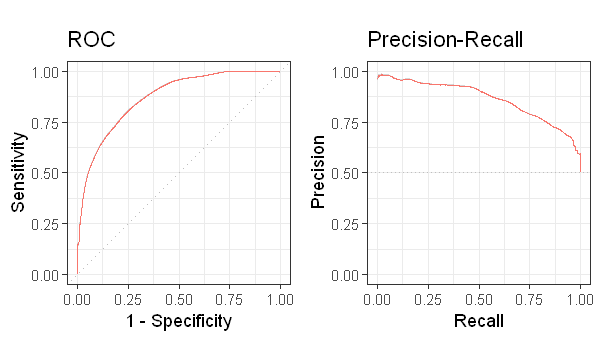

In [8]:
# Downsample predictions to get PR curve which can be compared to other models/TF libraries
downsampled_pred <- downSample(total_pred, total_pred$label)

# Prepare data for plotting
perf_data <- mmdata(split(downsampled_pred[["prob"]], downsampled_pred[["num"]]),
                    split(downsampled_pred[["label"]], downsampled_pred[["num"]]),
                    dsids = (c(1:n)))

# Calculate curves for multiple test datasets and keep all the curves
perf_curves <- evalmod(perf_data, raw_curves = TRUE)

# Show curves with the 95% confidence bounds
paste0('ROC AUC = ', as.data.frame(evalmod(scores = total_pred$prob, labels = total_pred$label, mode = 'aucroc'))[1,3])
paste0('PR AUC = ', auc(evalmod(scores = downsampled_pred$prob, label = as.integer(downsampled_pred$label)))[2,4])
options(repr.plot.width = 5, repr.plot.height = 3)
autoplot(perf_curves, show_cb = TRUE)

In [9]:
# Save LR model
save(lr_model, file = 'data/log_mod.RData')

pathways_hsa <- read_parquet('data/pathways_hsa_full_hg38.parquet')
pathways_hsa <- pathways_hsa[,c('gene_id','pathway')]
pathways_hsa$gene_id <- as.integer(pathways_hsa$gene_id)
pathways_hsa <- distinct(pathways_hsa)

go_hsa <- read_parquet('data/go_terms_hsa_processes.parquet')
go_hsa$gene_id <- as.integer(go_hsa$gene_id)
go_hsa <- distinct(go_hsa)

tf_names <- read_parquet('data/tf_names_hsa.parquet')
tf_names$index <- as.integer(tf_names[['__index_level_0__']])

save(pathways_hsa, go_hsa, tf_names, lr_model, file = 'data/sysdata.rda')